# Air-Quality Classification 🌬
___

## Objective 🥅

The objective of the challenge is to make a model based on Random Forests to classify the air quality based on the measurements retrieved from the laser sensors.

## Imports 📎

In [1]:
# Yolo!
import warnings
warnings.filterwarnings('ignore')

# Scientific and Data Manipulation Libraries :
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
from scipy.stats import kstest 
from pprint import pprint


# Visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.patches import ConnectionPatch
from matplotlib.colors import ListedColormap
import seaborn as sb
import ppscore as pps

# ML Pre-processing
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.metrics import accuracy_score, classification_report, recall_score, precision_score, confusion_matrix
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, RFECV
from sklearn.pipeline import Pipeline

# ML Models
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc, f1_score  


# Other Settings
%matplotlib inline
sb.set()

## Methods ⚙

In [2]:
# methods to go by
def check_distribution(df):
    '''Returns a Multiplot Histogram for each variable in input df '''
    # Inputs
    df = pd.DataFrame(df)
    variables = df.columns
    n_rows = 3
    n_cols = 4
    
    #Plot
    sb.set(font_scale=1.2) 
    fig=plt.figure(figsize=(15,7))
    fig.patch.set_facecolor('slategrey')
    fig.suptitle('FEATURE DISTRIBUTION')
    for i, var_name in enumerate(variables):
        ax=fig.add_subplot(n_rows,n_cols,i+1)
        df[var_name].hist(bins=25, ax=ax)
        ax.set_title(var_name, size=14)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
    fig.tight_layout()
    plt.show()
    plt.close('all')

    
def outliers(feature):
    '''Prints an outlier resume about one feature (ex: "df[AnyFeature]")'''    
    
    # calculate interquartile range
    q25, q75 = np.percentile(feature, 25), np.percentile(feature, 75)
    iqr = q75 - q25
    print(f'{feature.name.upper()}')
    print('Percentiles: 25th=%.3f, 75th=%.3f, IQR=%.3f' % (q25, q75, iqr))
    
    # calculate the outlier cutoff
    cut_off = iqr * 1.5
    lower, upper = q25 - cut_off, q75 + cut_off
    
    # identify outliers
    outliers = [x for x in feature if x < lower or x > upper]
    print('Identified outliers: %d' % len(outliers))
    
    # show outliers/non-outliers and percentage
    non_outliers = [x for x in feature if x >= lower and x <= upper]
    print('Non-outlier observations: %d' % len(non_outliers))
    proportion = len(outliers)/len(non_outliers)*100
    print(f'Outlier Percentage: {proportion:.2f} %\n')
    
    
def run_classifier(clf, param_grid, title):
    
    cv = StratifiedKFold(n_splits= 3, shuffle = True, random_state= 123)
    # Randomized grid search
    n_iter_search = 10
    gs = RandomizedSearchCV(clf, 
                            param_distributions = param_grid,
                            n_iter = n_iter_search, 
                            cv = cv, 
                            scoring= 'accuracy')
    
    # Train model
    gs.fit(X_train, y_train)  
    print("The best parameters are %s" % (gs.best_params_)) 
    # Predict on test set
    y_pred = gs.best_estimator_.predict(X_test)
    # Get Probability estimates
    y_prob = gs.best_estimator_.predict_proba(X_test)[:, 1]
   
    print('Accuracy score: %.2f%%' %(accuracy_score(y_test, y_pred)*100))  
    print('Precision score: %.2f%%' % (precision_score(y_test, y_pred, average= 'weighted')*100))
    print('Recall score: %.2f%%' % (recall_score(y_test, y_pred, average= 'weighted')*100))
    
    # Plot confusion matrix
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(10, 5))
    cm = confusion_matrix(y_test, y_pred)#, labels= target_names)
    sb.heatmap(cm, 
               annot = True, 
               cbar = False, 
               fmt = "d",
               linewidths = .5,
               cmap = "YlGnBu",
               ax = ax1)
    ax1.set_title("Confusion Matrix")
    ax1.set_xlabel("Predicted class")
    ax1.set_ylabel("Actual class")
    ax1.set_xticklabels(target_names)
    ax1.set_yticklabels(target_names)
    fig.tight_layout()
    # -----------------------------------------------------
    # Plot the decision boundary
    cmap = ListedColormap(colors[:len(np.unique(y_test))])
    # plot the decision surface
    x1_min, x1_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    x2_min, x2_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    resolution = 0.01 # step size in the mesh
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = gs.best_estimator_.predict(np.c_[xx1.ravel(), xx2.ravel()])
    # Put the result into a color plot
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    # plot class samples
    for idx, cl in enumerate(np.unique(y_test)):
        plt.scatter(x= X_test[y_test == cl, 0], 
                    y= X_test[y_test == cl, 1],
                    alpha= 0.8, 
                    c= colors[idx],
                    marker= markers[idx], 
                    label= target_names[cl], 
                    edgecolor= 'black')    
    ax2.set_title(title)
    ax2.set_xlabel("PC1")
    ax2.set_ylabel("PC2")
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())
    plt.xticks([]); plt.yticks([])
    plt.legend(loc='lower right')
    plt.show()       

## The Data 💾

Features: The dataset contains 8 features in 8 columns, which are the parameters measured by the different sensors. These correspond to the different interactions that the laser beams have had when passing through the air particles.

Target: The target corresponds to the 'label' that classifies the quality of the air.
- Target 0 corresponds to Good air quality 
- Target 1 corresponds to Moderate air quality
- Target 2 corresponds to Dangerous air quality

In [3]:
# first checks
df = pd.read_csv(r"C:\Users\motxi\Documents\HACKATHONS\NUWE\Air Quality Classification\train.csv",delimiter=';')
display(df.info())
display(df.describe())
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   feature1  2100 non-null   float64
 1   feature2  2100 non-null   float64
 2   feature3  2100 non-null   float64
 3   feature4  2100 non-null   float64
 4   feature5  2100 non-null   float64
 5   feature6  2100 non-null   float64
 6   feature7  2100 non-null   float64
 7   feature8  2100 non-null   float64
 8   target    2100 non-null   int64  
dtypes: float64(8), int64(1)
memory usage: 147.8 KB


None

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,target
count,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000,2100.000000
mean,-0.318846,0.005348,-0.327567,0.024042,0.085851,-0.065000,-0.025603,-0.004437,0.985238
std,1.575061,1.605428,1.479745,1.548154,1.788543,2.124337,1.015619,1.003342,0.815098
min,-5.031501,-6.004578,-5.470794,-5.296172,-5.719499,-4.910575,-3.850552,-3.541608,0.000000
25%,-1.406249,-1.119150,-1.368208,-1.083716,-1.136441,-1.613267,-0.701442,-0.659096,0.000000
50%,-0.431219,-0.162577,-0.532158,0.152545,0.102788,-0.431328,-0.007598,-0.019797,1.000000
75%,0.773896,1.127450,0.573801,1.173172,1.507492,1.162813,0.665932,0.667530,2.000000
max,5.388387,7.663112,4.869581,4.318758,6.033273,7.053420,4.400697,3.579874,2.000000


,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,target
0,-0.458258,-0.579012,2.886009,-0.075516,1.674060,-2.431912,0.534850,-0.846473,2
1,1.626615,-0.028332,-1.443184,-1.007447,-0.989093,1.202627,-0.038211,-1.298616,0
2,1.721356,-0.137676,-1.322593,-1.333187,-0.723713,0.843285,-0.588495,0.066682,0
3,-0.715103,3.265915,-0.791030,-2.967881,2.497628,-0.277387,-0.551611,0.668354,2
4,2.944098,0.197871,-2.257025,1.032789,-4.104693,4.716115,-0.380813,-1.393825,0


# EDA  🔬
____

Okay, so...Multi-label classification Problem and data features are encoded (this way we are unable to get extended knowledge about what is being measured by the lasers) although we could expect that the features might be somehow related with the usual indicators in this type of studies.

>...Pollutants tied to human and environmental health impacts include PM2.5, PM10, ground-level ozone, nitrogen dioxide and sulfur dioxide.[1]

There's no missing values and all features are numerical continuous. 

Most of the means are close to 0 and their standar deviations close to 1 so we could expect close to standard Normal Distributions

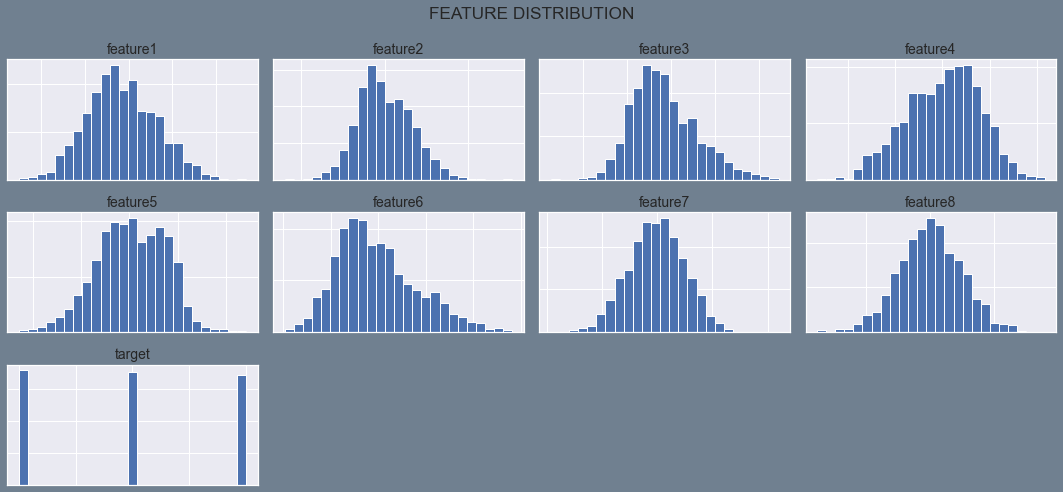

In [4]:
check_distribution(df)

Nice! All features are  close to a normal distribution and some are a bit skewed, besides we can see that the target variable is pretty balanced so I guess further transformations won't be needed.

Might have been previously standarized given it's nice shape and also the negative measurements since, a priori (call me naive), NO QUANTITATIVE PARTICLE MEASUREMENTS SHOULD HAVE NEGATIVE VALUES IF THEIR BLANK/BASELINE EQUALS COMPLETE ABSENCE OF SUCH PARTICLES.(**15 minutes later-->**) On the contrary I might as well be positively wrong since I'm unaware of the actual techniques used in the study and as far as I researched, the lasers must be "tuned" according to their target's spectroscopyc blueprint, and hence when speaking of pattern frequencies I suppose we could assume two bands (+/-).

>"The iodine infrared laser and the carbon dioxide infrared laser are forced to emit spectral lines which fall on the infrared absorption bands of atmospheric pollutants."[2]


### Target variable 🎯  

Since target is very balanced (as seen in the graphic above), there's no need to plot it again. Instead we could explore the kernel density estimations of each independent variables in comparison to the three possible values the target can have. This way we can get a sense of the relation between values mesured and quality of the air.

### Independent variables 🧱


- Check outliers

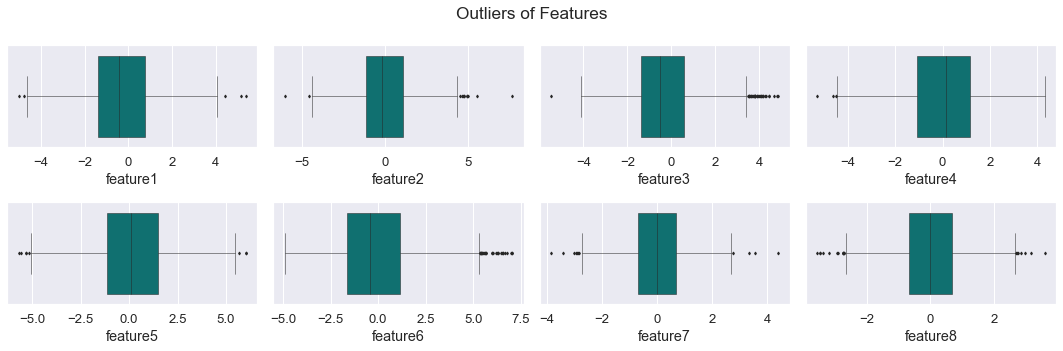

FEATURE1
Percentiles: 25th=-1.406, 75th=0.774, IQR=2.180
Identified outliers: 5
Non-outlier observations: 2095
Outlier Percentage: 0.24 %

FEATURE2
Percentiles: 25th=-1.119, 75th=1.127, IQR=2.247
Identified outliers: 12
Non-outlier observations: 2088
Outlier Percentage: 0.57 %

FEATURE3
Percentiles: 25th=-1.368, 75th=0.574, IQR=1.942
Identified outliers: 33
Non-outlier observations: 2067
Outlier Percentage: 1.60 %

FEATURE4
Percentiles: 25th=-1.084, 75th=1.173, IQR=2.257
Identified outliers: 3
Non-outlier observations: 2097
Outlier Percentage: 0.14 %

FEATURE5
Percentiles: 25th=-1.136, 75th=1.507, IQR=2.644
Identified outliers: 8
Non-outlier observations: 2092
Outlier Percentage: 0.38 %

FEATURE6
Percentiles: 25th=-1.613, 75th=1.163, IQR=2.776
Identified outliers: 29
Non-outlier observations: 2071
Outlier Percentage: 1.40 %

FEATURE7
Percentiles: 25th=-0.701, 75th=0.666, IQR=1.367
Identified outliers: 11
Non-outlier observations: 2089
Outlier Percentage: 0.53 %

FEATURE8
Percentiles: 2

In [5]:
# all boxplots & outliers
fig = plt.figure(figsize=(15,5))
for i in range(1,9,1) :       
    plt.subplot(2,4,i)           
    sb.boxplot(x=df['feature'+ str(i)],color='teal', linewidth=0.5, fliersize=2)
plt.suptitle('Outliers of Features')   
plt.tight_layout()
plt.show()
plt.close()

# outliers
for i in range(1,9,1):
    outliers(df['feature' + str(i)])

Features nº 3 & 6 have the highest percentage of outliers (**1.6% & 1.4% respectively**) yet they are far below 5% and since we're told to use RF  algorithms (wich are robust against outliers and non-normality) we could already do fine with this data.

- Check Distribution

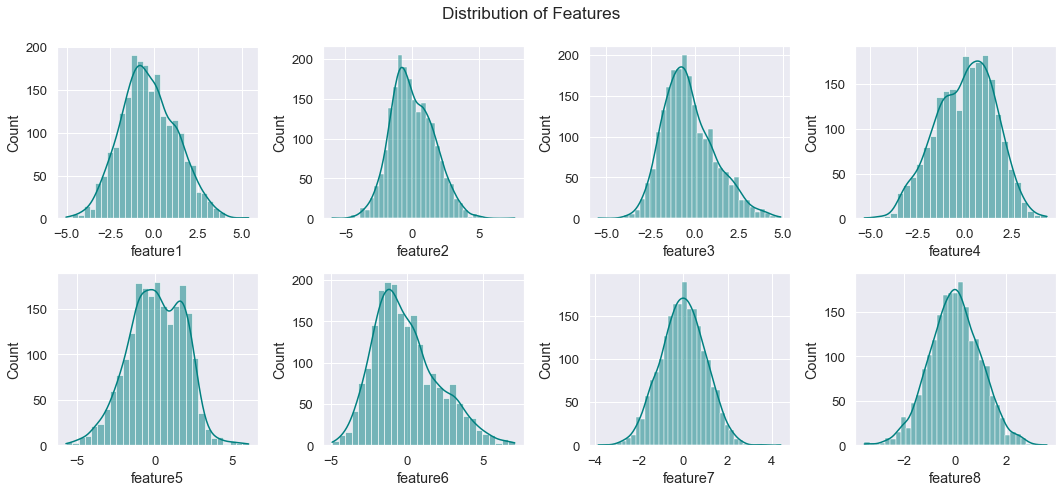

In [6]:
# plot distribution plus kde
fig = plt.figure(figsize=(15,7))
for i in range(1,9,1) :       
    plt.subplot(2,4,i)           
    sb.histplot(x=df['feature'+ str(i)],color='teal', kde=True)
plt.suptitle('Distribution of Features')   
plt.tight_layout()
plt.show()
plt.close()


Regarding their patterns, features 7 & 8 seem very very close, so I guess reducing the noise their correlation adds could help if we wanted to try some Linear Algorithms since these would bennefit greatly from the normality exhibited and the small percentages of Outliers (**I'm fully aware the objective is to use Random Forest. This might just be an idea to compare performances amongst different models or use ensemble models with linear estimators, just for the sake of trying it**)

- Probability Estimates of each target per feature

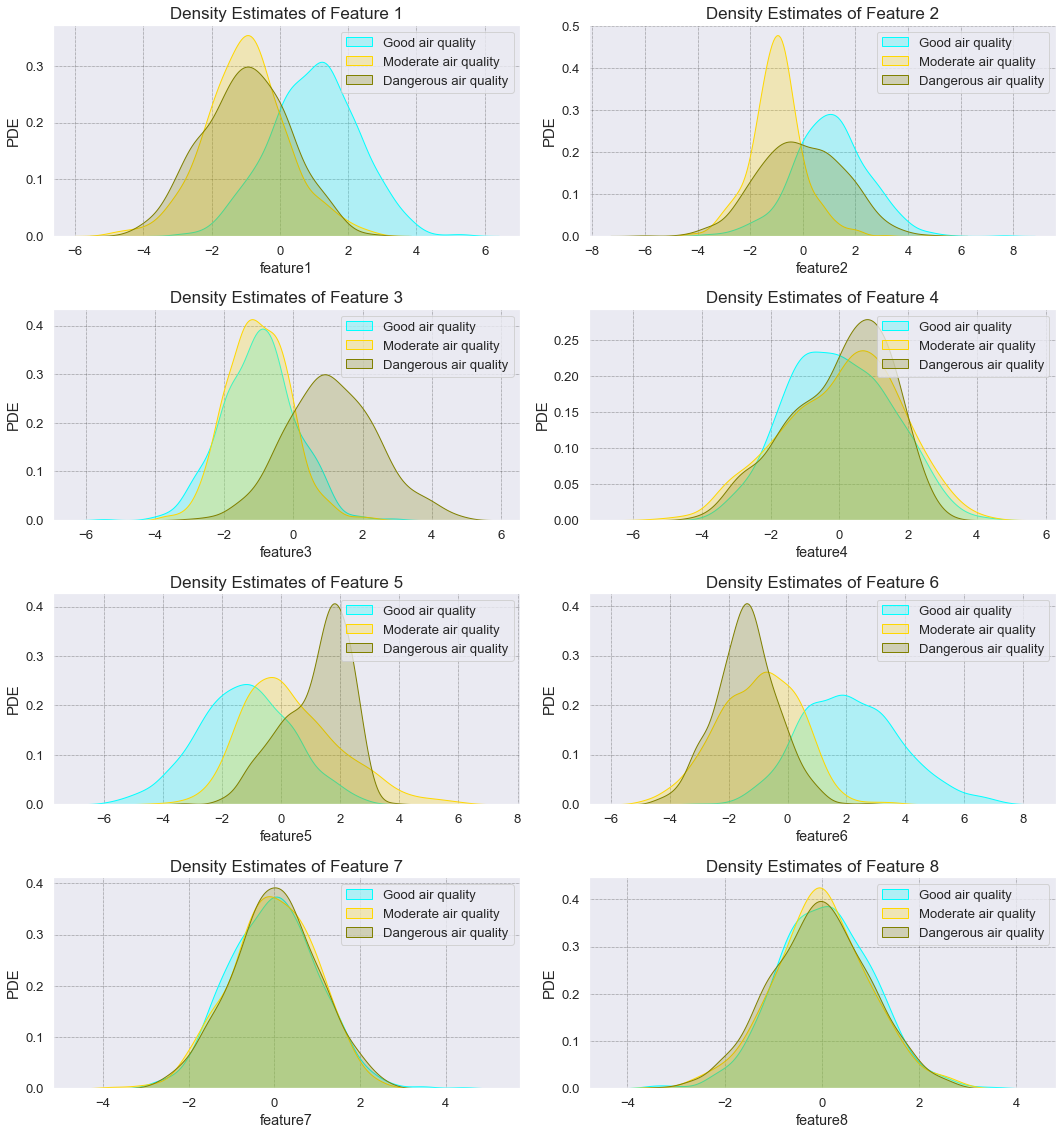

In [7]:
# plot kde's for each outcome and feature
fig = plt.figure(figsize=(15,16))
for i in range(1,9,1) : 
    # each subplot data
    plt.subplot(4,2,i)  
    sb.kdeplot(df.loc[(df['target'] == 0),'feature'+ str(i)], color='cyan', shade=True)
    sb.kdeplot(df.loc[(df['target'] == 1), 'feature'+ str(i)], color='gold', shade=True)
    sb.kdeplot(df.loc[(df['target'] == 2), 'feature'+ str(i)], color='olive', shade=True)

    # aestethics
    plt.ylabel("PDE", fontsize = 15)
    plt.title(f'Density Estimates of Feature {i}', fontsize=17)
    plt.grid(color='k', linestyle='dotted', linewidth=0.5)
    plt.legend(labels=['Good air quality', 'Moderate air quality', 'Dangerous air quality'])

plt.tight_layout()
plt.show()

Well...there's a lot going on here:

1. Intuitively we would expect that measuring any toxic component (like NO<sub>2</sub> or CO<sub>2</sub> concentrations) rendered a pattern similar to *feature5*. This is with positive correlation between the feature values and the "Toxicity" of the air (i.e. *more feature5 = more toxicity*).


2. Yet *features 1 & 6* (and *feature2* to a lesser extent) display a negative correlation, meaning lower probability of Good air quality associated to bigger values. ¿🤔? (curious face due to naivety)


3. Also *features 7 & 8* keep being so similar in their "Very Gaussian" shapes as well as their own estimations in relation to the target. As seen, we could expect either both features to be deemed irrelevant towards the target variable (showing near-null predictive power) or maybe the data distribution was previously altered in such way that our analysis becomes irelevant at this point. 

## Correlation and Collinearity 🔗



First we're plotting a 2d representation of each feature pairwise combined to check their relationship. Ideally, what we would like to see are well defined clusters where the colors are clearly separated.

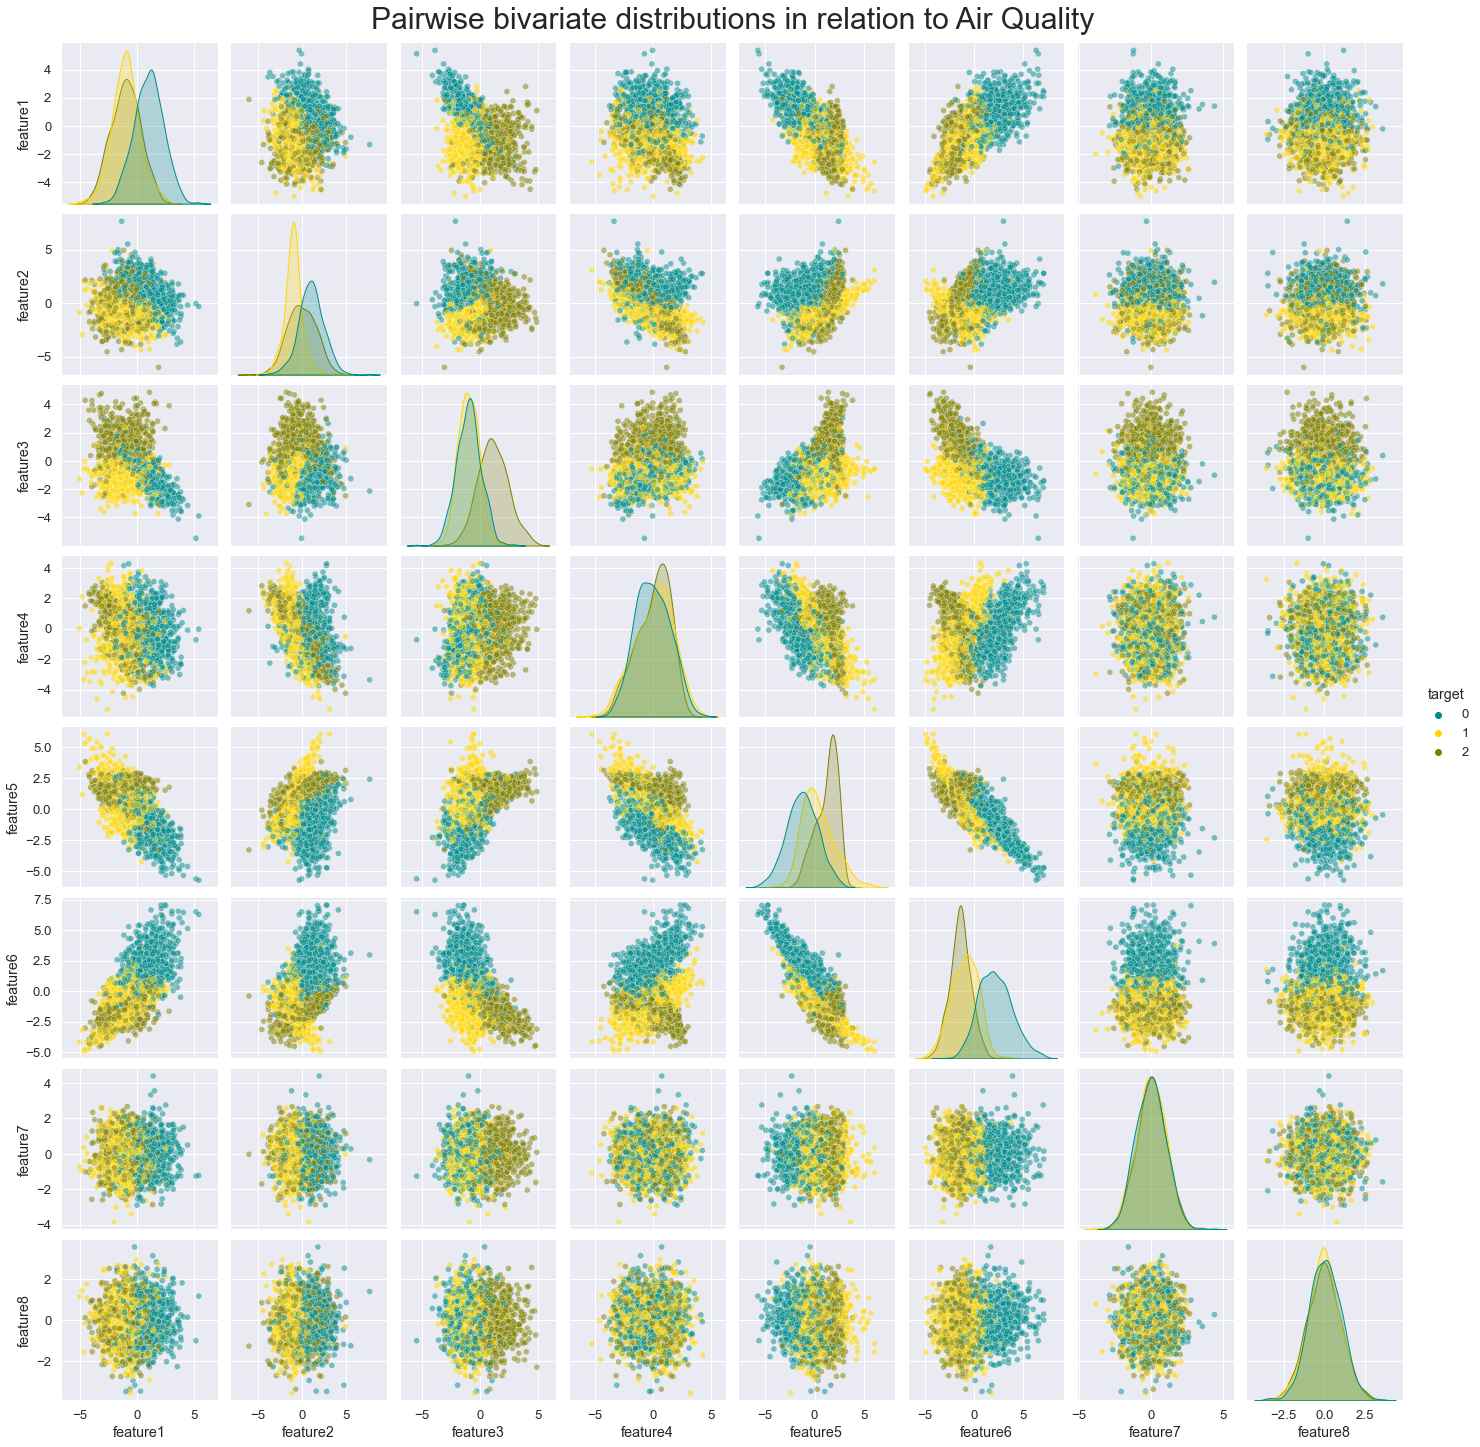

In [8]:
# get pairplot
sb.pairplot(df, hue='target', kind='scatter',
            palette=['darkcyan','gold','olive'],
            plot_kws={'alpha':0.5})
plt.suptitle('Pairwise bivariate distributions in relation to Air Quality', fontsize=30, y=1.01)
plt.show()
plt.close()

Okay...some pairs of features exhibit linear relationships (e.g. features 5 & 6) whereas others clearly don't (e.g. features 4 & 7).

Good air quality seems to be more defined whereas Moderate/Dangerous tend to overlap each other. This latter might offer a hint about the impact on the Precision in our Model Scores.

Just to theorize...it seems to me that the pattern similarities between features 7 & 8 might mean that both are somehow similar in their nature and the fact that they don't add predictive power might mean that both are ubiquitous to all observations, hence I'd dare to guess that these two features correspond to the Particulate Matter readings (i.e. PM10 and PM2.5)

Now with the correlation matrices

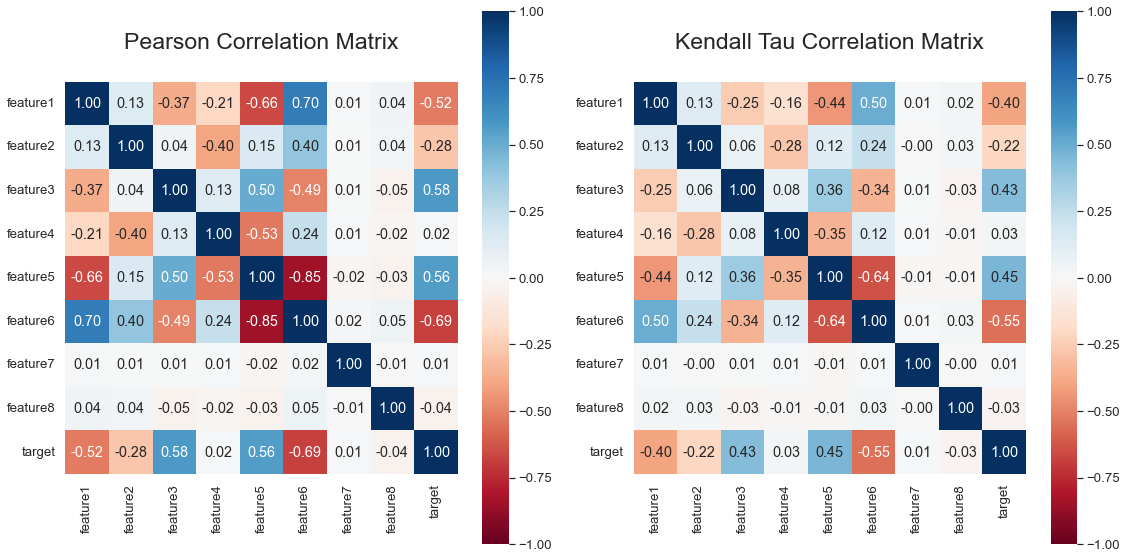

In [9]:
# get corr matrixes (Linear+Monotonic)
df_corr_p = df.corr(method='pearson')
df_corr_kt = df.corr(method='kendall')
# Plot
colormap = plt.cm.RdBu
fig,(ax1,ax2) = plt.subplots(1,2, figsize=(16,8))

 
# plotting a triangle correlation heatmap
dataplot = sb.heatmap(data=df_corr_p,
                      square=True,
                      annot=True,
                      fmt=".2f",
                      cmap='RdBu',
                      linecolor = 'black',
                      vmin=-1,
                      center=0,
                      vmax=1,
                      ax=ax1)
ax1.set_title('Pearson Correlation Matrix', fontsize=23, y=1.07)
 
# plotting a triangle correlation heatmap
dataplot = sb.heatmap(data=df_corr_kt,
                      square=True,
                      annot=True,
                      fmt=".2f",
                      cmap='RdBu',
                      vmin=-1,
                      center=0,
                      vmax=1,
                      ax=ax2)
ax2.set_title("Kendall Tau Correlation Matrix", fontsize=23, y=1.07)
plt.tight_layout()
sb.set_style()
plt.show()
plt.close()

Pearson's Correlation : This is for Linear Relationships 
- Assuring what we saw before in the pairplot, features 1, 5 and 6 present the highest values in terms of linear correlation, and features 7 & 8 get the lowest correlation values.

- Regarding the relationship with the target feature, correlations are moderate and feature 3 joins the group.

Kendall-Tau's Correlation : This explores Monotonic relationships 
- In this case maximum values show moderate correlations, both matrix color patterns ressemble each other to a different degree.

Next we will use Predictive Power Score wich is a type of non-symetryc correlation. Basically it shows the predictive power of each variable over each variable (unidirectional) , the X axis features are considered as if Independent variables and the Y axis features as if the target feature

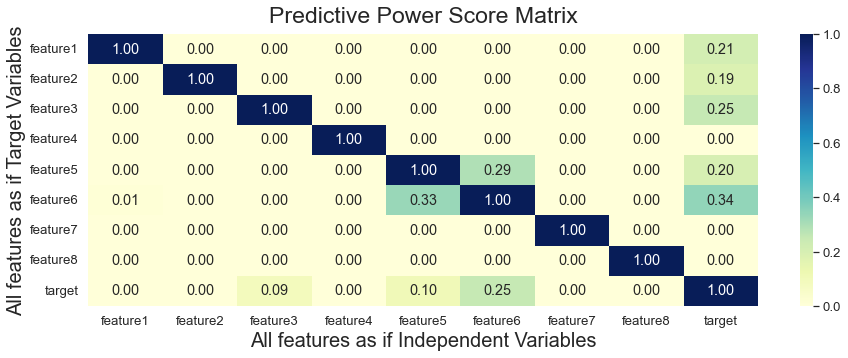

In [10]:
# plot PPS
plt.figure(figsize=(15,5))
matrix_df = pps.matrix(df)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')
sb.heatmap(data=matrix_df, 
           vmin=0, 
           vmax=1,
           fmt=".2f",
           cmap="YlGnBu",
           linewidths=0,
           annot=True
          )
plt.title("Predictive Power Score Matrix", fontsize=23, y=1.02)
plt.xlabel('All features as if Independent Variables', fontsize=20)
plt.ylabel('All features as if Target Variables', fontsize=20)
plt.show()
plt.close()

The PPS shows that feature6 can predict the target better than feature5.

Distributions a priori seem Normal and Outliers are negligible, anyways we'll check Normality tests as qqplots and Kolmogorov-Smirnov tests this latter with a fixed p=0.05 and assuming normality as the Null hypothesis.

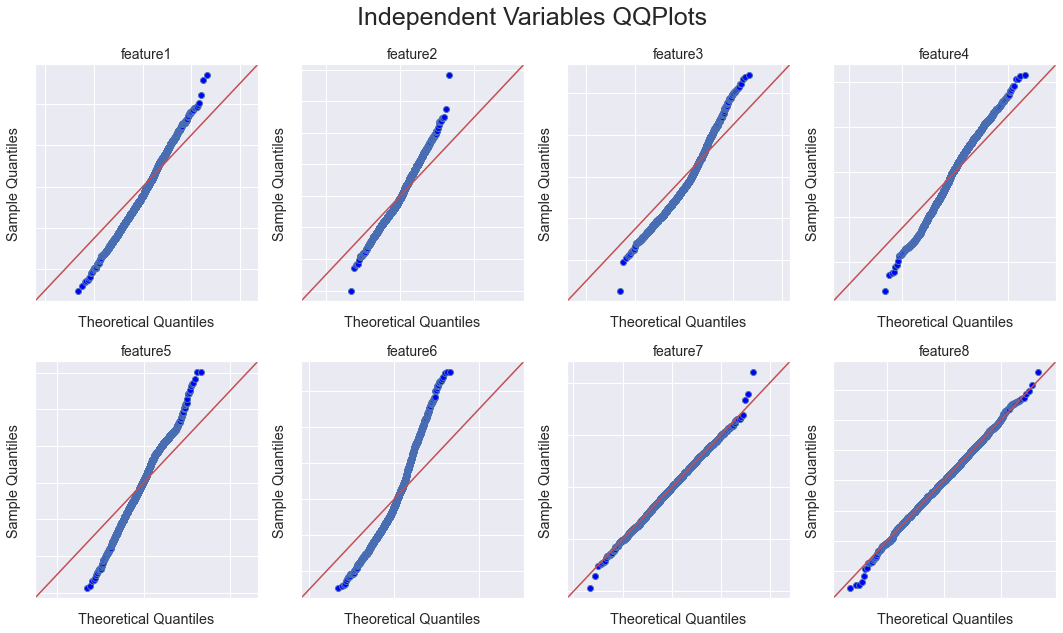

Kolmogorov-Smirnov test

FEATURE1 :
pvalue=9.488948808687915e-71 | Distribution is NOT NORMAL

FEATURE2 :
pvalue=2.714101336797105e-31 | Distribution is NOT NORMAL

FEATURE3 :
pvalue=1.2152951268621696e-80 | Distribution is NOT NORMAL

FEATURE4 :
pvalue=9.640865846451675e-34 | Distribution is NOT NORMAL

FEATURE5 :
pvalue=1.5315007533503994e-68 | Distribution is NOT NORMAL

FEATURE6 :
pvalue=6.21242553088153e-98 | Distribution is NOT NORMAL

FEATURE7 :
pvalue=0.44837796611502445 | Distribution is  NORMAL

FEATURE8 :
pvalue=0.7868915609040487 | Distribution is  NORMAL


In [11]:
# first split (X,y)
X = df.drop(columns=['target'], axis=1)
y = df[['target']]

# qqplots
fig = plt.figure(figsize=(15,9))
for i, var_name in enumerate(X.columns):
        ax=fig.add_subplot(2,4,i+1)
        sm.qqplot(X[var_name], line='45', ax=ax)

        ax.set_title(var_name, size=14)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
plt.suptitle('Independent Variables QQPlots',fontsize=25)
plt.tight_layout()
plt.show()
plt.close()

# Kolmogorov-Smirnov
print('Kolmogorov-Smirnov test')
for feature in X.columns:
    print(f'\n{feature.upper()} :')
    p = kstest(df[feature],'norm').pvalue
    if p<0.05:
        print(f'pvalue={p} | Distribution is NOT NORMAL')
    else:
        print(f'pvalue={p} | Distribution is  NORMAL')

According to the results above, only features 7 and 8 could be drawn from a Normal distribution. 

## Feature Engineering 🧩

### Train/Test Split

In [12]:
# split and check shapes
X_train, X_test, y_train, y_test = (train_test_split(X,y, test_size=0.30, random_state=1))

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (1470, 8)
y_train shape: (1470, 1)
X_test shape: (630, 8)
y_test shape: (630, 1)


### Standardization and Power Transforms

We will keep 4 sets of X_train:

The reasons behind this are that I want to keep track of the models based on their type and the nature of the inputs besides as an alternative approach to the problem I'd like to check any performance improvement in an Ensemble Voting Classifier Model composed by an ensemble of  models wich relay on euclidean distances and/or assume a gaussian distribution. 

1. The good ol' X_train (Unmodified); All Tree based type algorithms should do fine since don't assume much, and the data is quite clean with near-zero mean/no nans & outliers/close to unit variance.


2. X_train_std (StandardScaled) ; Suposedly all Euclidean distance based Algorithms would bennefit from it given the Normal-ish distribution of the features. We just changed values closer to mean 0 and unit variance although haven't altered distribution...yet😈

3. X_train_nonoise (With features 5, 7 & 8 removed from the standarized set) 

4. X_train_tr (PowerTransformed) ; Here we alter the distribution to make the data ressemble more normal than it is.maybe it's not needed but we'll check anyway. 


X_TRAIN SKEWNESS ABSOLUTE VALUES (Raw data)


,skew
feature6,0.610327
feature3,0.551341
feature2,0.365366
feature4,0.235392
feature1,0.151549
feature5,0.151298
feature8,0.053632
feature7,0.005727


,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,-0.317290,-0.005383,-0.300846,0.041411,0.081868,-0.070822,-0.019933,0.007127
std,1.580273,1.603552,1.482357,1.536863,1.765970,2.091408,1.019192,1.012848
min,-5.031501,-6.004578,-5.470794,-5.296172,-5.719499,-4.910575,-3.850552,-3.541608
25%,-1.436113,-1.110242,-1.341120,-1.033819,-1.105263,-1.572864,-0.697254,-0.639321
50%,-0.445349,-0.206198,-0.523162,0.158117,0.089243,-0.418383,-0.005079,-0.008267
75%,0.787202,1.100676,0.604505,1.146224,1.492337,1.143341,0.671101,0.690001
max,5.388387,7.663112,4.780738,4.318758,6.033273,6.780155,4.400697,3.579874


BEFORE (X_train)


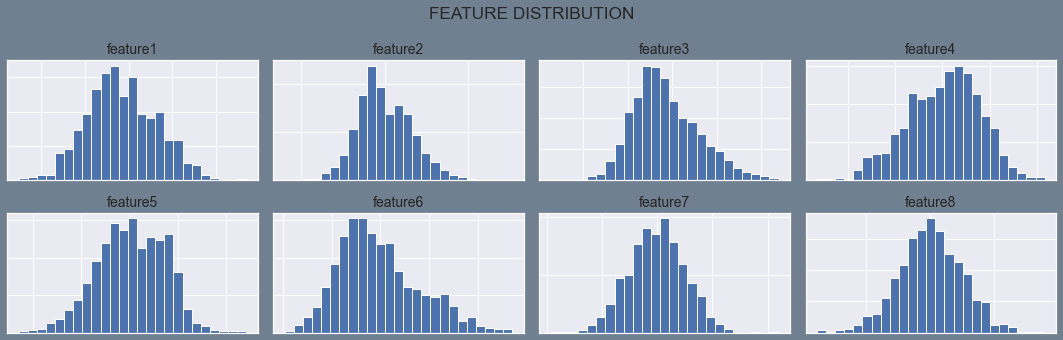


AFTER (X_train_std)


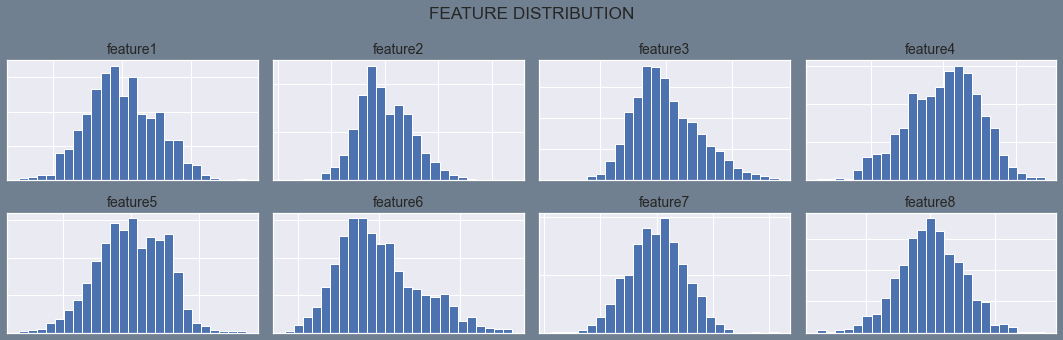


X_TRAIN SKEWNESS ABSOLUTE VALUES (StandardScaler)


,skew
feature6,0.610327
feature3,0.551341
feature2,0.365366
feature4,0.235392
feature1,0.151549
feature5,0.151298
feature8,0.053632
feature7,0.005727


,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8
count,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03
mean,-1.049803e-17,-3.669589e-17,-1.535053e-17,-2.044850e-17,1.918345e-17,2.152473e-17,-3.402418e-17,-2.447022e-17
std,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00
min,-2.984178e+00,-3.742463e+00,-3.488840e+00,-3.474220e+00,-3.286207e+00,-2.314900e+00,-3.759765e+00,-3.504912e+00
25%,-7.082346e-01,-6.892417e-01,-7.020086e-01,-6.998645e-01,-6.724551e-01,-7.184414e-01,-6.647924e-01,-6.384654e-01
50%,-8.106316e-02,-1.252738e-01,-1.500253e-01,7.596351e-02,4.177547e-03,-1.662418e-01,1.457908e-02,-1.520362e-02
75%,6.991627e-01,6.899899e-01,6.109591e-01,7.191197e-01,7.989655e-01,5.807455e-01,6.782519e-01,6.744409e-01
max,3.611794e+00,4.783819e+00,3.429210e+00,2.784115e+00,3.371196e+00,3.276888e+00,4.338863e+00,3.528628e+00


In [13]:
# Skew before
skew_feats = X_train.skew().abs().sort_values(ascending=False)
skewness = pd.DataFrame({'skew': skew_feats})
print("\nX_TRAIN SKEWNESS ABSOLUTE VALUES (Raw data)")
display(skewness)
display(X_train.describe())
# No scaled
print('BEFORE (X_train)')
check_distribution(X_train)

# standardize data
scaler = StandardScaler()
X_train_std = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_std = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

print('\nAFTER (X_train_std)')
check_distribution(X_train_std)

# Skew after
skew_feats = X_train_std.skew().abs().sort_values(ascending=False)
skewness = pd.DataFrame({'skew': skew_feats})
print("\nX_TRAIN SKEWNESS ABSOLUTE VALUES (StandardScaler)")
display(skewness)
display(X_train_std.describe())




BEFORE (X_train)


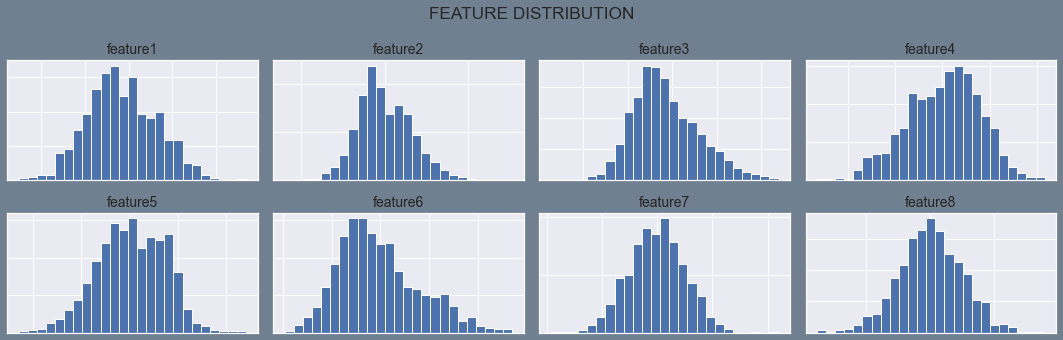


AFTER (X_train_tr)


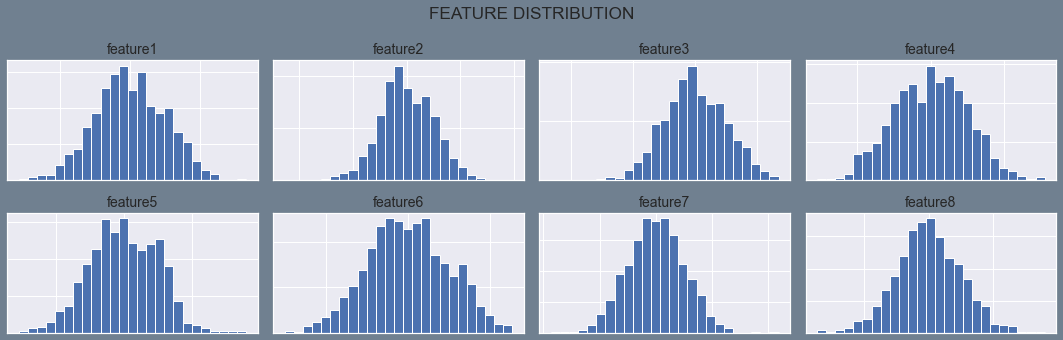

X_train_tr SKEWNESS ABSOLUTE VALUES (Power Transforms)


,skew
feature2,0.038388
feature3,0.020571
feature8,0.013793
feature7,0.008079
feature4,0.007024
feature1,0.005782
feature5,0.004987
feature6,0.000567


,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8
count,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03,1.470000e+03
mean,-3.481720e-17,2.869964e-18,1.888134e-19,2.499890e-17,-3.391089e-17,-2.084500e-17,-1.476521e-17,-3.549693e-17
std,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00,1.000340e+00
min,-3.193749e+00,-4.539585e+00,-4.664553e+00,-3.095544e+00,-3.087334e+00,-3.022914e+00,-3.735670e+00,-3.448868e+00
25%,-6.980391e-01,-6.653921e-01,-6.816630e-01,-7.272374e-01,-6.881830e-01,-6.966000e-01,-6.660225e-01,-6.420564e-01
50%,-4.719359e-02,-5.113393e-02,-4.089580e-02,2.051951e-02,-2.725084e-02,-2.930351e-02,1.198556e-02,-2.202941e-02
75%,7.178592e-01,7.294402e-01,7.003842e-01,7.024102e-01,7.935311e-01,6.850384e-01,6.770578e-01,6.714143e-01
max,3.333167e+00,3.943236e+00,2.706890e+00,3.105559e+00,3.606236e+00,2.556328e+00,4.370420e+00,3.587430e+00


In [14]:
# Power transforms

print('BEFORE (X_train)')
check_distribution(X_train)

# object transform
pt = PowerTransformer(method='yeo-johnson', standardize=True)

# transform with Yeo-Johnson
X_train_tr = pd.DataFrame(pt.fit_transform(X_train), columns = X.columns)
X_test_tr = pd.DataFrame(pt.transform(X_test), columns = X.columns)

print('\nAFTER (X_train_tr)')
check_distribution(X_train_tr)

# Skew after
skew_feats = X_train_tr.skew().abs().sort_values(ascending=False)
skewness = pd.DataFrame({'skew': skew_feats})
print("X_train_tr SKEWNESS ABSOLUTE VALUES (Power Transforms)")
display(skewness)
display(X_train_tr.describe())

## Feature Selection 🃏

### Recursive Feature Elimination with Cross-Validation. 

- This algorithm uses a supervised learning estimator that has built-in cross-validation capabilities and provides information about feature importance by removing one feature at a time.


- As estimators I prefer to use a mixture of linear & non_linear MLAlgorithm types just to control their behaviour with the data, given it's transformations.


 LogisticRegression()
Feature Ranking: [1 1 1 3 2 1 4 5]
Optimal number of features : 4

 LinearDiscriminantAnalysis()
Feature Ranking: [1 1 1 4 2 1 3 5]
Optimal number of features : 4

 AdaBoostClassifier()
Feature Ranking: [1 1 1 1 1 1 1 1]
Optimal number of features : 8

 DecisionTreeClassifier()
Feature Ranking: [1 1 1 1 2 1 3 4]
Optimal number of features : 5

 RandomForestClassifier()
Feature Ranking: [1 1 1 1 1 1 2 3]
Optimal number of features : 6

 GradientBoostingClassifier()
Feature Ranking: [1 1 1 1 1 1 2 3]
Optimal number of features : 6


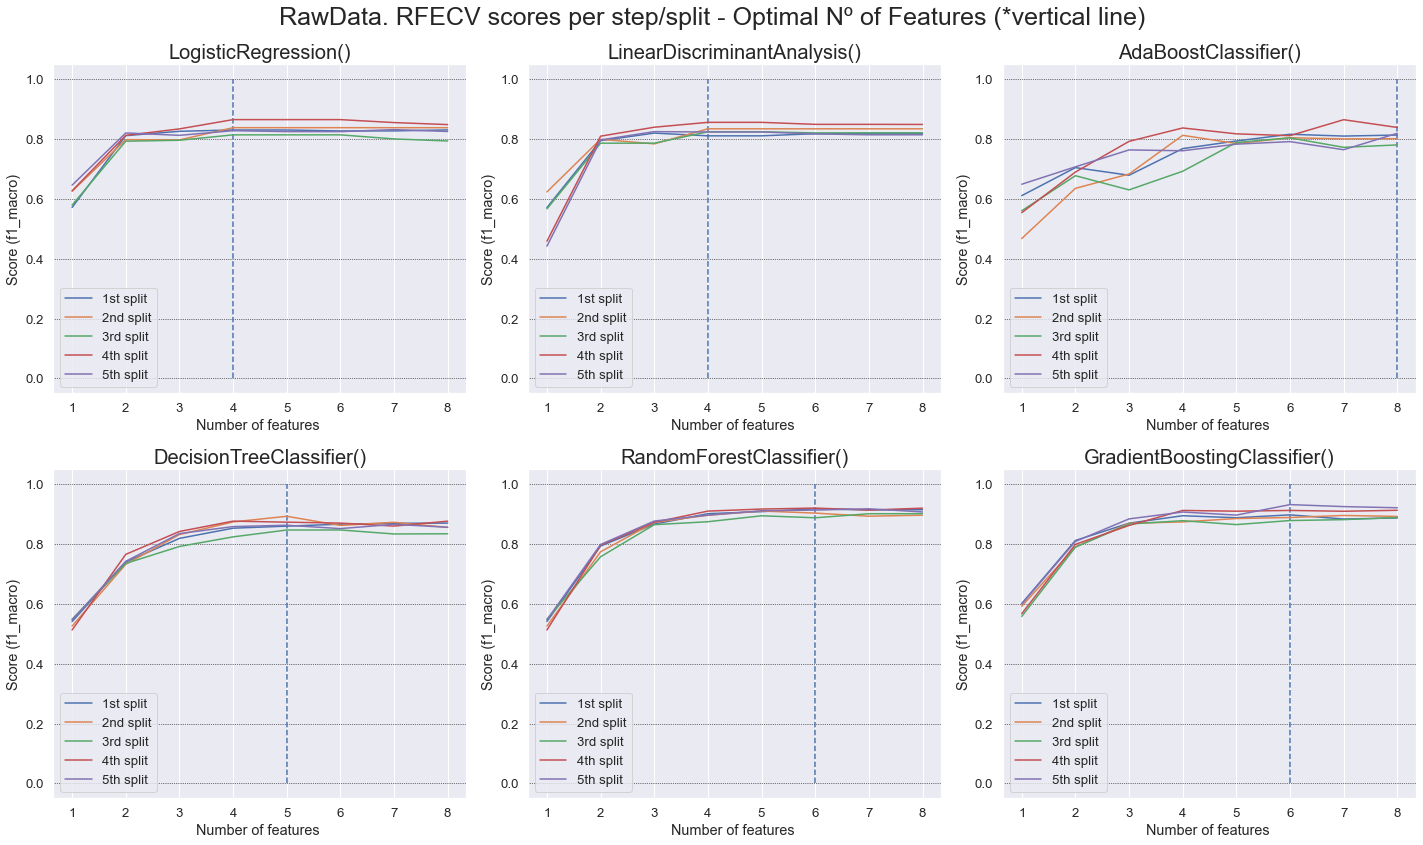

In [15]:
# set kfold cv and general parameters 
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

# Create the RFE objects and compute a cross-validated score.
models = [LogisticRegression(), 
          LinearDiscriminantAnalysis(),
          AdaBoostClassifier(),
          DecisionTreeClassifier(), 
          RandomForestClassifier(),
          GradientBoostingClassifier()]


fig = plt.figure(figsize=(20,12))
for i,model in enumerate(models):
    rfecv = RFECV(estimator=model,
                  n_jobs=-1,
                  cv=kfold,
                  scoring="f1_macro",
                  )
    
    rfecv.fit(X_train, y_train)
    print('\n',str(model))
    print(f"Feature Ranking: {rfecv.ranking_}")
    print(f"Optimal number of features : {rfecv.n_features_}")

    # Plot number of features VS. cross-validation scores
    plt.subplot(2,3,i+1)
    plt.vlines(x=rfecv.n_features_, ymin=0, ymax=1, linestyle='--')
    plt.xlabel("Number of features ")
    plt.ylabel("Score (f1_macro)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1),
             rfecv.grid_scores_,
             label=['1st split', '2nd split', '3rd split', '4th split', '5th split'],
             )
    plt.title(str(model), fontsize=20)
    plt.legend(loc='lower left')
    plt.grid(color='black', linestyle='dotted', linewidth=0.7, axis='y')
plt.suptitle('RawData. RFECV scores per step/split - Optimal Nº of Features (*vertical line)', fontsize=25)
plt.tight_layout()
plt.show()


 LogisticRegression()
Feature Ranking: [1 1 1 3 2 1 4 5]
Optimal number of features : 4

 LinearDiscriminantAnalysis()
Feature Ranking: [1 1 1 1 1 1 2 3]
Optimal number of features : 6

 AdaBoostClassifier()
Feature Ranking: [1 1 1 1 1 1 1 1]
Optimal number of features : 8

 DecisionTreeClassifier()
Feature Ranking: [1 1 1 1 2 1 3 4]
Optimal number of features : 5

 RandomForestClassifier()
Feature Ranking: [1 1 1 1 1 1 2 3]
Optimal number of features : 6

 GradientBoostingClassifier()
Feature Ranking: [1 1 1 1 1 1 2 3]
Optimal number of features : 6


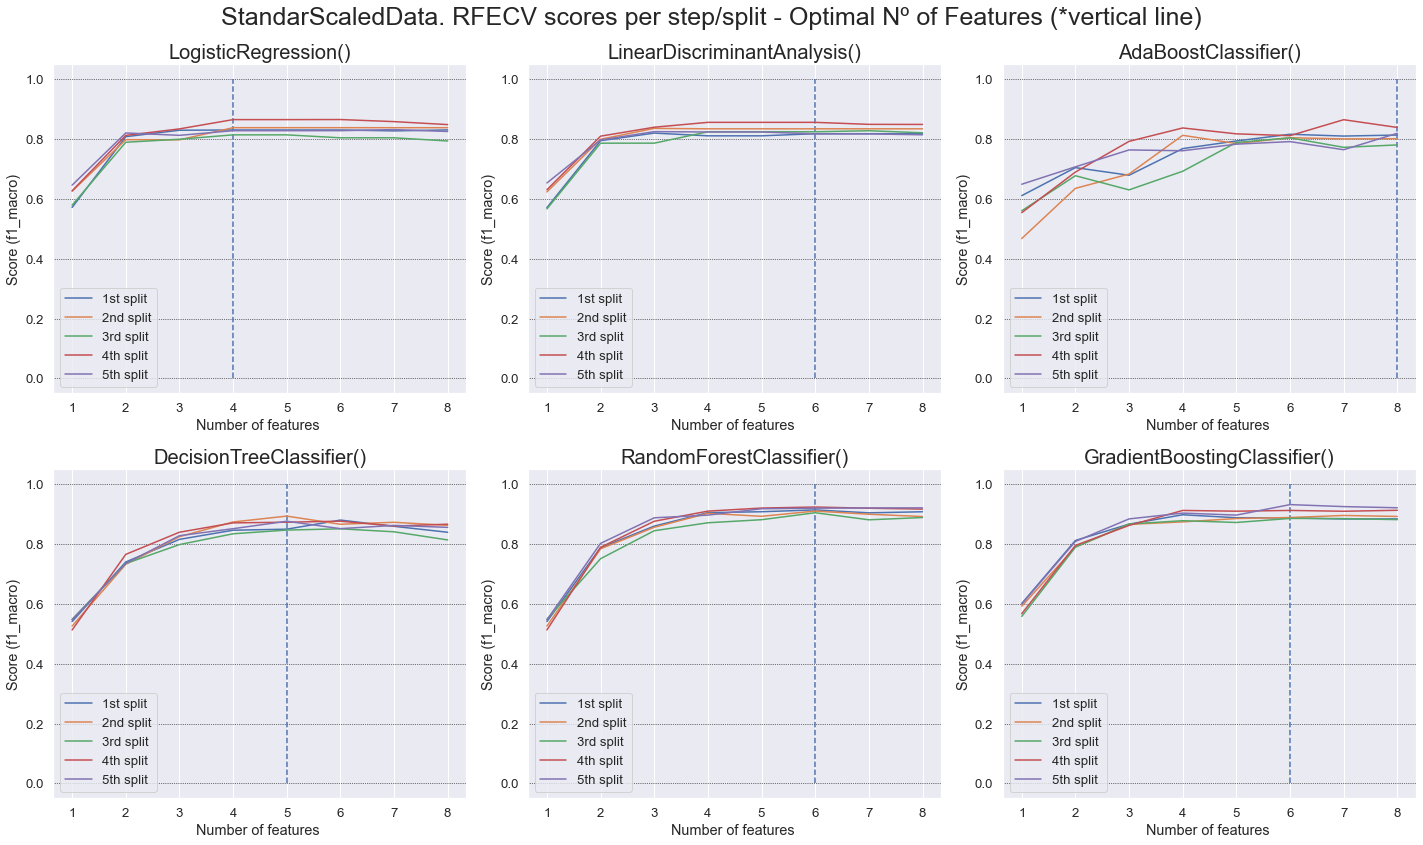

In [16]:
# Create the RFE objects and compute a cross-validated score.
models = [LogisticRegression(), 
          LinearDiscriminantAnalysis(),
          AdaBoostClassifier(),
          DecisionTreeClassifier(), 
          RandomForestClassifier(),
          GradientBoostingClassifier()]

# set kfold cv and general parameters 
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

fig = plt.figure(figsize=(20,12))
for i,model in enumerate(models):
    rfecv = RFECV(estimator=model,
                  n_jobs=-1,
                  cv=kfold,
                  scoring="f1_macro",
                  )
    
    rfecv.fit(X_train_std, y_train)
    print('\n',str(model))
    print(f"Feature Ranking: {rfecv.ranking_}")
    print(f"Optimal number of features : {rfecv.n_features_}")

    # Plot number of features VS. cross-validation scores
    plt.subplot(2,3,i+1)
    plt.vlines(x=rfecv.n_features_, ymin=0, ymax=1, linestyle='--')
    plt.xlabel("Number of features ")
    plt.ylabel("Score (f1_macro)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1),
             rfecv.grid_scores_,
             label=['1st split', '2nd split', '3rd split', '4th split', '5th split'],
             )
    plt.title(str(model), fontsize=20)
    plt.legend(loc='lower left')
    plt.grid(color='black', linestyle='dotted', linewidth=0.7, axis='y')
    
plt.suptitle('StandarScaledData. RFECV scores per step/split - Optimal Nº of Features (*vertical line)', fontsize=25)
plt.tight_layout()
plt.show()


 LogisticRegression()
Feature Ranking: [1 1 1 1 1 1 2 3]
Optimal number of features : 6

 LinearDiscriminantAnalysis()
Feature Ranking: [1 1 1 1 1 1 1 2]
Optimal number of features : 7

 AdaBoostClassifier()
Feature Ranking: [1 1 1 1 1 1 1 1]
Optimal number of features : 8

 DecisionTreeClassifier()
Feature Ranking: [1 1 1 1 2 1 3 4]
Optimal number of features : 5

 RandomForestClassifier()
Feature Ranking: [1 1 1 1 1 1 1 2]
Optimal number of features : 7

 GradientBoostingClassifier()
Feature Ranking: [1 1 1 1 1 1 2 3]
Optimal number of features : 6


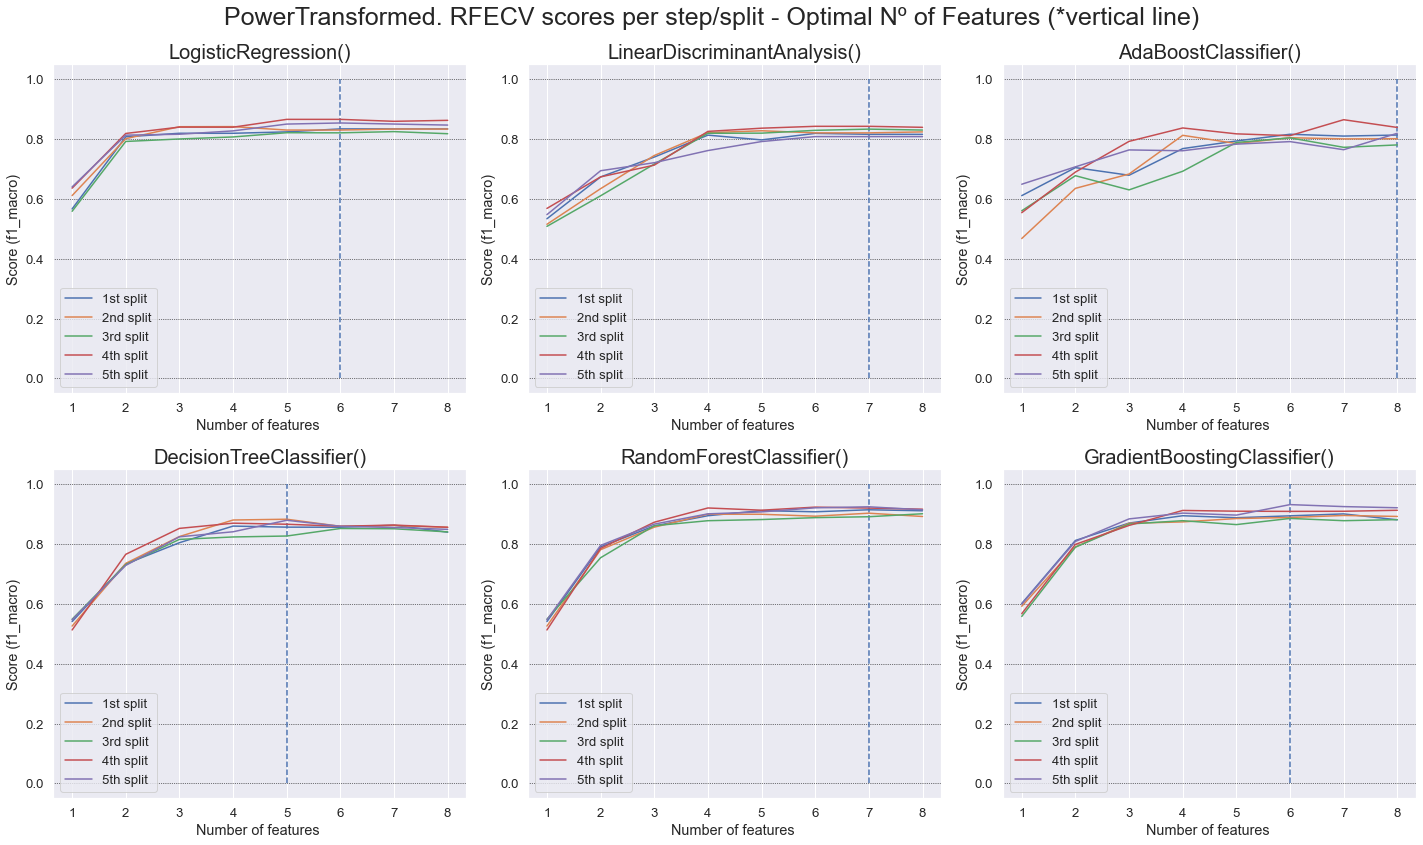

In [17]:
# Create the RFE objects and compute a cross-validated score.
models = [LogisticRegression(), 
          LinearDiscriminantAnalysis(),
          AdaBoostClassifier(),
          DecisionTreeClassifier(), 
          RandomForestClassifier(),
          GradientBoostingClassifier()]

# set kfold cv and general parameters 
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

fig = plt.figure(figsize=(20,12))
for i,model in enumerate(models):
    rfecv = RFECV(estimator=model,
                  n_jobs=-1,
                  cv=kfold,
                  scoring="f1_macro",
                  )
    
    rfecv.fit(X_train_tr, y_train)
    print('\n',str(model))
    print(f"Feature Ranking: {rfecv.ranking_}")
    print(f"Optimal number of features : {rfecv.n_features_}")

    # Plot number of features VS. cross-validation scores
    plt.subplot(2,3,i+1)
    plt.vlines(x=rfecv.n_features_, ymin=0, ymax=1, linestyle='--')
    plt.xlabel("Number of features ")
    plt.ylabel("Score (f1_macro)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1),
             rfecv.grid_scores_,
             label=['1st split', '2nd split', '3rd split', '4th split', '5th split'],
             )
    plt.title(str(model), fontsize=20)
    plt.legend(loc='lower left')
    plt.grid(color='black', linestyle='dotted', linewidth=0.7, axis='y')
plt.suptitle('PowerTransformed. RFECV scores per step/split - Optimal Nº of Features (*vertical line)', fontsize=25)
plt.tight_layout()
plt.show()

- Most models rank of features consider features7 & 8 the least important. 

- Besides the linear models may suffer some drawback due the high correlation between features 5 & 6. 

- 🤔So...since feature6 describes better the target according to PPS, we could make a "noise-reduced" set off of the already standardized inputs dropping features 5 & 7 and see how linear/EuclideanDistance based Algorithms react to it.

In [18]:
X_train_nonoise = X_train_std.drop(columns=['feature6', 'feature7','feature8'], axis=1)
X_test_nonoise = X_test_std.drop(columns=['feature6', 'feature7','feature8'], axis=1)

X_train_tr = X_train_tr.drop(columns=['feature6', 'feature7','feature8'], axis=1)
X_test_tr = X_test_tr.drop(columns=['feature6', 'feature7','feature8'], axis=1)


## Algorithm Spot-Checking 🔮

We select a different types Algortihms to see their cross validated scores with the different treatment of the data: 
- Linear: 
    1. Logistic Regressor
    2. LDA

    
- Nonlinear:
    3. KNN
    4. Decision Tree
    5. RF
    6. Gradient Bosting Classifier
    7. Ada
    8. Voting Classifier

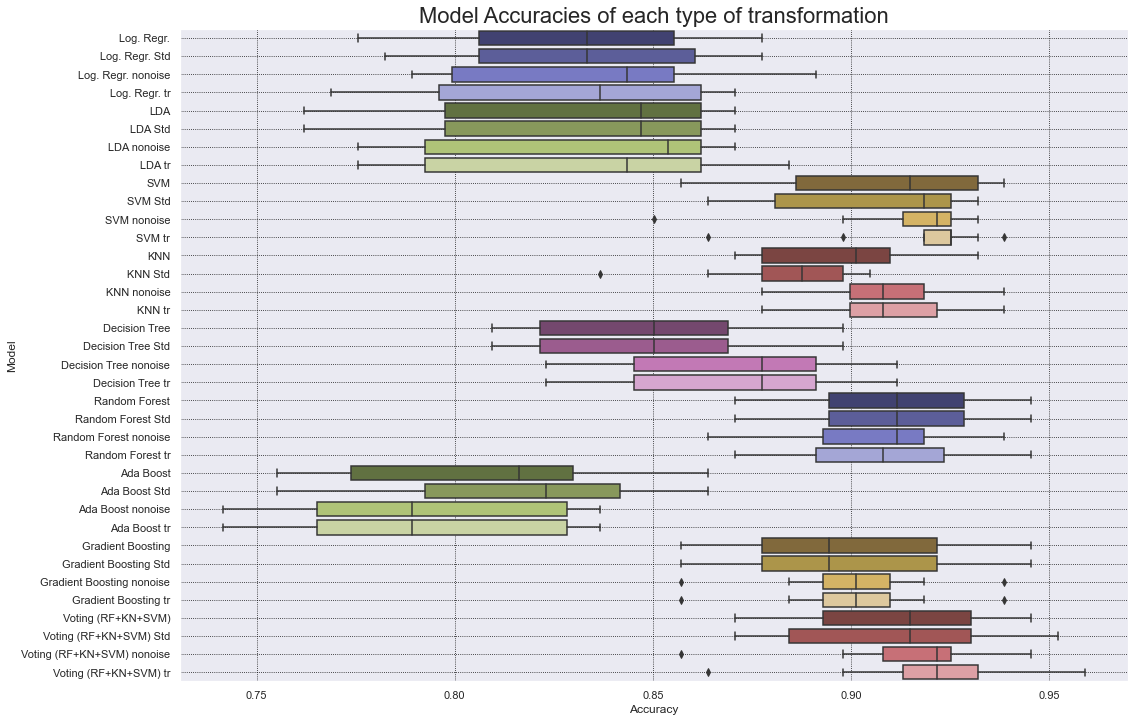

,Log. Regr.,Log. Regr. Std,Log. Regr. nonoise,Log. Regr. tr,LDA,LDA Std,LDA nonoise,LDA tr,SVM,SVM Std,...,Ada Boost nonoise,Ada Boost tr,Gradient Boosting,Gradient Boosting Std,Gradient Boosting nonoise,Gradient Boosting tr,Voting (RF+KN+SVM),Voting (RF+KN+SVM) Std,Voting (RF+KN+SVM) nonoise,Voting (RF+KN+SVM) tr
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.829252,0.830612,0.834014,0.827891,0.829932,0.829932,0.831973,0.829932,0.906803,0.905442,...,0.793197,0.793197,0.897959,0.897959,0.900680,0.900680,0.912245,0.910204,0.915646,0.919728
std,0.034606,0.034157,0.034568,0.038887,0.038748,0.038748,0.037815,0.040437,0.029048,0.025138,...,0.037149,0.037149,0.029911,0.029911,0.021560,0.021560,0.024517,0.027735,0.024881,0.025615
min,0.775510,0.782313,0.789116,0.768707,0.761905,0.761905,0.775510,0.775510,0.857143,0.863946,...,0.741497,0.741497,0.857143,0.857143,0.857143,0.857143,0.870748,0.870748,0.857143,0.863946
25%,0.806122,0.806122,0.799320,0.795918,0.797619,0.797619,0.792517,0.792517,0.886054,0.880952,...,0.765306,0.765306,0.877551,0.877551,0.892857,0.892857,0.892857,0.884354,0.908163,0.913265
50%,0.833333,0.833333,0.843537,0.836735,0.846939,0.846939,0.853741,0.843537,0.914966,0.918367,...,0.789116,0.789116,0.894558,0.894558,0.901361,0.901361,0.914966,0.914966,0.921769,0.921769
75%,0.855442,0.860544,0.855442,0.862245,0.862245,0.862245,0.862245,0.862245,0.931973,0.925170,...,0.828231,0.828231,0.921769,0.921769,0.909864,0.909864,0.930272,0.930272,0.925170,0.931973
max,0.877551,0.877551,0.891156,0.870748,0.870748,0.870748,0.870748,0.884354,0.938776,0.931973,...,0.836735,0.836735,0.945578,0.945578,0.938776,0.938776,0.945578,0.952381,0.945578,0.959184


In [76]:
#'''Didn't use methods for the sake of clarity but then I started
# adding variants (not being quite pythonic this time I guess)'''

# Get dict to store scores
d = {}

# set kfold cv and general parameters 
kfold = KFold(n_splits=10, shuffle=True, random_state=0)
num_trees = 150

# Logistic regression
model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
results_lr = cross_val_score(model, X_train, y_train, cv=kfold)
d['Log. Regr.'] = results_lr

# Logistic regression std
model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
results_lr_std = cross_val_score(model, X_train_std, y_train, cv=kfold)
d['Log. Regr. Std'] = results_lr_std

# Logistic regression nonoise
model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
results_lr_nonoise = cross_val_score(model, X_train_nonoise , y_train, cv=kfold)
d['Log. Regr. nonoise'] = results_lr_nonoise

# Logistic regression tr
model = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
results_lr_tr = cross_val_score(model, X_train_tr , y_train, cv=kfold)
d['Log. Regr. tr'] = results_lr_tr

# Linear Discriminant Analysis
model = LinearDiscriminantAnalysis()
results_lda = cross_val_score(model, X_train, y_train, cv=kfold)
d['LDA'] = results_lda

# Linear Discriminant Analysis std
model = LinearDiscriminantAnalysis()
results_lda_std = cross_val_score(model, X_train_std, y_train, cv=kfold)
d['LDA Std'] = results_lda_std

# Linear Discriminant Analysis tr
model = LinearDiscriminantAnalysis()
results_lda_nonoise = cross_val_score(model, X_train_nonoise, y_train, cv=kfold)
d['LDA nonoise'] = results_lda_nonoise

# Linear Discriminant Analysis tr
model = LinearDiscriminantAnalysis()
results_lda_tr = cross_val_score(model, X_train_tr, y_train, cv=kfold)
d['LDA tr'] = results_lda_tr

# Support Vector mAchines
model = SVC(random_state=0)
results_svm = cross_val_score(model, X_train, y_train, cv=kfold)
d['SVM'] = results_svm

# Support Vector mAchines std
model = SVC(random_state=0)
results_svm_std = cross_val_score(model, X_train_std, y_train, cv=kfold)
d['SVM Std'] = results_svm_std

# Support Vector mAchines nonoise
model = SVC(random_state=0)
results_svm_nonoise = cross_val_score(model, X_train_nonoise, y_train, cv=kfold)
d['SVM nonoise'] = results_svm_nonoise

# Support Vector mAchines tr
model = SVC(random_state=0)
results_svm_tr = cross_val_score(model, X_train_tr, y_train, cv=kfold)
d['SVM tr'] = results_svm_tr

# K-Nearest Neighbors
model = KNeighborsClassifier()
results_knn = cross_val_score(model, X_train, y_train, cv=kfold)
d['KNN'] = results_knn

# K-Nearest Neighbors std
model = KNeighborsClassifier()
results_knn_std = cross_val_score(model, X_train_std, y_train, cv=kfold)
d['KNN Std'] = results_knn_std

# K-Nearest Neighbors nonoise
model = KNeighborsClassifier()
results_knn_nonoise = cross_val_score(model, X_train_nonoise, y_train, cv=kfold)
d['KNN nonoise'] = results_knn_nonoise

# K-Nearest Neighbors tr
model = KNeighborsClassifier()
results_knn_tr = cross_val_score(model, X_train_tr, y_train, cv=kfold)
d['KNN tr'] = results_knn_tr

# Decision Tree Classifier
model = DecisionTreeClassifier(random_state=0)
results_dt = cross_val_score(model, X_train, y_train, cv=kfold)
d['Decision Tree'] = results_dt

# Decision Tree Classifier
model = DecisionTreeClassifier(random_state=0)
results_dt_std = cross_val_score(model, X_train_std, y_train, cv=kfold)
d['Decision Tree Std'] = results_dt_std

# Decision Tree Classifier
model = DecisionTreeClassifier(random_state=0)
results_dt_nonoise = cross_val_score(model, X_train_nonoise, y_train, cv=kfold)
d['Decision Tree nonoise'] = results_dt_nonoise

# Decision Tree Classifier
model = DecisionTreeClassifier(random_state=0)
results_dt_tr = cross_val_score(model, X_train_tr, y_train, cv=kfold)
d['Decision Tree tr'] = results_dt_tr

# Random Forest Tree Algorithm
model = RandomForestClassifier(n_estimators=num_trees, random_state=0)
results_rf = cross_val_score(model, X_train, y_train, cv=kfold)
d['Random Forest'] = results_rf

# Random Forest Tree Algorithm
model = RandomForestClassifier(n_estimators=num_trees, random_state=0)
results_rf_std = cross_val_score(model, X_train_std, y_train, cv=kfold)
d['Random Forest Std'] = results_rf_std

# Random Forest Tree Algorithm
model = RandomForestClassifier(criterion='entropy', n_estimators=num_trees, random_state=0)
results_rf_nonoise = cross_val_score(model, X_train_nonoise, y_train, cv=kfold)
d['Random Forest nonoise'] = results_rf_nonoise

# Random Forest Tree Algorithm
model = RandomForestClassifier(n_estimators=num_trees, random_state=0)
results_rf_tr = cross_val_score(model, X_train_tr, y_train, cv=kfold)
d['Random Forest tr'] = results_rf_tr


# Ada Boosting
model = AdaBoostClassifier(random_state=0)
results_ada = cross_val_score(model, X_train, y_train, cv=kfold)
d['Ada Boost'] = results_ada

# Ada Boosting
model = AdaBoostClassifier(n_estimators=num_trees, random_state=0)
results_ada_std = cross_val_score(model, X_train_std, y_train, cv=kfold)
d['Ada Boost Std'] = results_ada_std

# Ada Boosting
model = AdaBoostClassifier(n_estimators=num_trees, random_state=0)
results_ada_nonoise = cross_val_score(model, X_train_nonoise, y_train, cv=kfold)
d['Ada Boost nonoise'] = results_ada_nonoise

# Ada Boosting
model = AdaBoostClassifier(n_estimators=num_trees, random_state=0)
results_ada_tr = cross_val_score(model, X_train_tr, y_train, cv=kfold)
d['Ada Boost tr'] = results_ada_tr

# Gradient Boosting
model = GradientBoostingClassifier(n_estimators=num_trees, random_state=0)
results_gb = cross_val_score(model, X_train, y_train, cv=kfold)
d['Gradient Boosting'] = results_gb

# Gradient Boosting std
model = GradientBoostingClassifier(n_estimators=num_trees, random_state=0)
results_gb_std = cross_val_score(model, X_train_std, y_train, cv=kfold)
d['Gradient Boosting Std'] = results_gb_std

# Gradient Boosting tr
model = GradientBoostingClassifier(n_estimators=num_trees, random_state=0)
results_gb_nonoise = cross_val_score(model, X_train_nonoise, y_train, cv=kfold)
d['Gradient Boosting nonoise'] = results_gb_nonoise

# Gradient Boosting tr
model = GradientBoostingClassifier(n_estimators=num_trees, random_state=0)
results_gb_tr = cross_val_score(model, X_train_tr, y_train, cv=kfold)
d['Gradient Boosting tr'] = results_gb_tr

# Voting ensemble
    # create the sub models 
estimators = []
model1 = RandomForestClassifier()
estimators.append(('lda', model1))
model2 = SVC()
estimators.append(('svc', model2))
model3 = KNeighborsClassifier()
estimators.append(('KNeigh.Clasif.', model3))
    # create the ensemble model
ensemble = VotingClassifier(estimators)
results_vc = cross_val_score(ensemble, X_train, y_train, cv=kfold)
d['Voting (RF+KN+SVM)'] = results_vc

# Voting ensemble
    # create the sub models 
estimators = []
model1 = RandomForestClassifier()
estimators.append(('lda', model1))
model2 = SVC()
estimators.append(('svc', model2))
model3 = KNeighborsClassifier()
estimators.append(('KNeigh.Clasif.', model3))
    # create the ensemble model
ensemble = VotingClassifier(estimators)
results_vc_std = cross_val_score(ensemble, X_train_std, y_train, cv=kfold)
d['Voting (RF+KN+SVM) Std'] = results_vc_std

# Voting ensemble
    # create the sub models 
estimators = []
model1 = RandomForestClassifier()
estimators.append(('lda', model1))
model2 = SVC()
estimators.append(('svc', model2))
model3 = KNeighborsClassifier()
estimators.append(('KNeigh.Clasif.', model3))
    # create the ensemble model
ensemble = VotingClassifier(estimators)
results_vc_nonoise = cross_val_score(ensemble, X_train_nonoise, y_train, cv=kfold)
d['Voting (RF+KN+SVM) nonoise'] = results_vc_nonoise

# Voting ensemble
    # create the sub models 
estimators = []
model1 = RandomForestClassifier()
estimators.append(('lda', model1))
model2 = SVC()
estimators.append(('svc', model2))
model3 = KNeighborsClassifier()
estimators.append(('KNeigh.Clasif.', model3))
    # create the ensemble model
ensemble = VotingClassifier(estimators)
results_vc_tr = cross_val_score(ensemble, X_train_tr, y_train, cv=kfold)
d['Voting (RF+KN+SVM) tr'] = results_vc_tr

# convert dict to dataframe
scores_df = pd.DataFrame(d)

# plot boxes
fig = plt.figure(figsize=(17,12))
sb.boxplot(data=scores_df, palette='tab20b', orient='horizontal')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.title('Model Accuracies of each type of transformation', fontsize=22)
plt.grid(color='black', linestyle='dotted', linewidth=0.8)
plt.show()
plt.close()

# display statistics
display(scores_df.describe())

Well...according to above:
- Standarization only improves scores significantly in the case of Ada Boost Algorithm. Wich I indeed found strange since the default learner is a Decision Tree and It's median scores are substantially better. 
  
  
- Logistic regression gets use of the succesive transformations we did.


- KNeighbors Classifier and Support Vector Machines improve both their accuraccy and precision when the highly correlated & non-informative features are removed (*no-noise*), nevertheless when we remove the same features from the PowerTransformed train set (*tr*) the scores only improve in the case of the Voting Ensemble Method since both methods are part of the ensemble.
   
   
- Whereas standardization of the data generally doesn't improve the scoring in CART types like the RF or Decision Tree since they don't rely on any assumptions about the normality given their own nature , the reduction of the noise really does the job according to the RFECV feature selection process, when the majority of used models suggested 6 features.

### Preselected MLAlgorithms

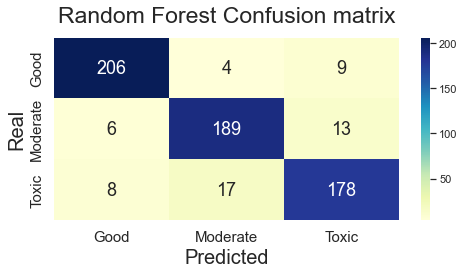

              precision    recall  f1-score   support

           0     0.9364    0.9406    0.9385       219
           1     0.9000    0.9087    0.9043       208
           2     0.8900    0.8768    0.8834       203

    accuracy                         0.9095       630
   macro avg     0.9088    0.9087    0.9087       630
weighted avg     0.9094    0.9095    0.9094       630
 



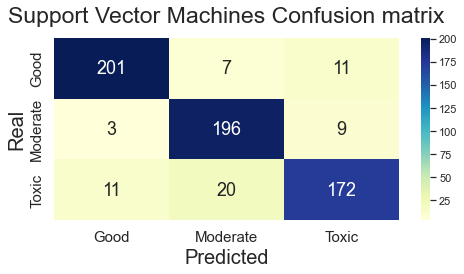

              precision    recall  f1-score   support

           0     0.9349    0.9178    0.9263       219
           1     0.8789    0.9423    0.9095       208
           2     0.8958    0.8473    0.8709       203

    accuracy                         0.9032       630
   macro avg     0.9032    0.9025    0.9022       630
weighted avg     0.9038    0.9032    0.9029       630
 



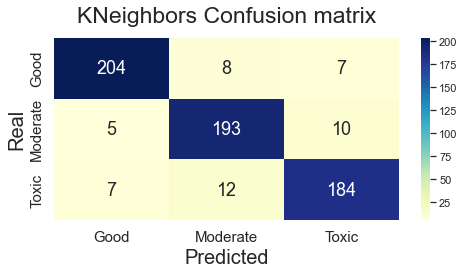

              precision    recall  f1-score   support

           0     0.9444    0.9315    0.9379       219
           1     0.9061    0.9279    0.9169       208
           2     0.9154    0.9064    0.9109       203

    accuracy                         0.9222       630
   macro avg     0.9220    0.9219    0.9219       630
weighted avg     0.9224    0.9222    0.9223       630
 



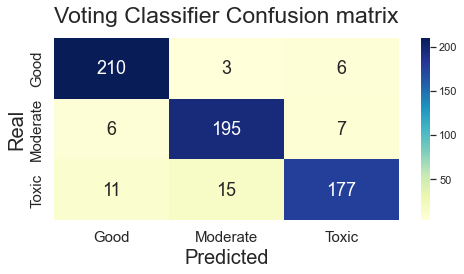

              precision    recall  f1-score   support

           0     0.9251    0.9589    0.9417       219
           1     0.9155    0.9375    0.9264       208
           2     0.9316    0.8719    0.9008       203

    accuracy                         0.9238       630
   macro avg     0.9241    0.9228    0.9229       630
weighted avg     0.9240    0.9238    0.9234       630
 



In [67]:
# Create Object RF
rfc_clasif = RandomForestClassifier(random_state=1)
# Train the model
rfc_clasif.fit(X_train_nonoise, y_train)
# Predict Values
y_predictions = rfc_clasif.predict(X_test_nonoise)
# plotting matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_predictions)
fig, ax = plt.subplots(1,1,figsize=(7,4))
labels = ['Good','Moderate','Toxic']
# create heatmap
sb.set()
sb.heatmap(pd.DataFrame(cnf_matrix),
           annot=True,
           cmap="YlGnBu" ,
           fmt='g', 
           annot_kws={"size":18})
plt.ylabel('Real',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
ax.set_xticklabels(labels, minor=False, fontsize=15)
ax.set_yticklabels(labels, minor=False, fontsize=15)

plt.title('Random Forest Confusion matrix',y=1.05, fontsize=23)
plt.tight_layout()
plt.show()
plt.close()
print(classification_report(y_test, y_predictions, digits=4), '\n')


# Create SVM Object
svm = SVC(random_state=0)
# Train the model
svm.fit(X_train_nonoise, y_train)
# Predict Values
y_predictions = svm.predict(X_test_nonoise)
# plotting matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_predictions)
fig, ax = plt.subplots(1,1,figsize=(7,4))
labels = ['Good','Moderate','Toxic']
# create heatmap
sb.set()
sb.heatmap(pd.DataFrame(cnf_matrix),
           annot=True,
           cmap="YlGnBu" ,
           fmt='g', 
           annot_kws={"size":18})

plt.ylabel('Real',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
ax.set_xticklabels(labels, minor=False, fontsize=15)
ax.set_yticklabels(labels, minor=False, fontsize=15)

plt.title('Support Vector Machines Confusion matrix',y=1.05, fontsize=23)
plt.tight_layout()
plt.show()
plt.close()
print(classification_report(y_test, y_predictions, digits=4), '\n')


# Create Object KNN
kn = KNeighborsClassifier()
# Train the model
kn.fit(X_train_nonoise, y_train)
# Predict Values
y_predictions = kn.predict(X_test_nonoise)
# plotting matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_predictions)
fig, ax = plt.subplots(1,1,figsize=(7,4))
labels = ['Good','Moderate','Toxic']
# create heatmap
sb.set()
sb.heatmap(pd.DataFrame(cnf_matrix),
           annot=True,
           cmap="YlGnBu" ,
           fmt='g', 
           annot_kws={"size":18})

plt.ylabel('Real',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
ax.set_xticklabels(labels, minor=False, fontsize=15)
ax.set_yticklabels(labels, minor=False, fontsize=15)

plt.title('KNeighbors Confusion matrix',y=1.05, fontsize=23)
plt.tight_layout()
plt.show()
plt.close()

print(classification_report(y_test, y_predictions, digits=4), '\n')


# Create Voting ensemble
    # the sub models 
estimators = []
model1 = RandomForestClassifier(random_state=0)
estimators.append(('lda', model1))
#model2 = SVC(kernel='linear', random_state=0)
#estimators.append(('svc', model2))
model3 = KNeighborsClassifier()
estimators.append(('KNeigh.Clasif.', model3))
#model4 = GradientBoostingClassifier(random_state=0)
#estimators.append(('GradientBoosting', model4)) 
    # create the ensemble model
ensemble = VotingClassifier(estimators)

# Train the model
ensemble.fit(X_train_nonoise, y_train)
# Predict Values
y_predictions = ensemble.predict(X_test_nonoise)
# plotting matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_predictions)
fig, ax = plt.subplots(1,1,figsize=(7,4))
labels = ['Good','Moderate','Toxic']
# create heatmap
sb.set()
sb.heatmap(pd.DataFrame(cnf_matrix),
           annot=True,
           cmap="YlGnBu" ,
           fmt='g', 
           annot_kws={"size":18})

plt.ylabel('Real',fontsize=20)
plt.xlabel('Predicted',fontsize=20)
ax.set_xticklabels(labels, minor=False, fontsize=15)
ax.set_yticklabels(labels, minor=False, fontsize=15)

plt.title('Voting Classifier Confusion matrix',y=1.05, fontsize=23)
plt.tight_layout()
plt.show()
plt.close()

print(classification_report(y_test, y_predictions, digits=4), '\n')

>It turns out Voting method beats all scores when removing SVC() from the ensemble. This greater score cames at the cost of the false negatives regarding Toxic air quality, so...it's the best accuracy and contains a random forest model but...


## Hyper-Parameter Tuning 🔩


### Random forest

In [96]:
rfc=RandomForestClassifier(random_state=2)

param_grid = {'n_estimators': [50, 100, 150, 200],
              'min_samples_split': [1,2,3],
              'max_depth' : [2,3,4,5,6],
              'criterion' : ['gini', 'entropy'],
              'class_weight': ['balanced']
             }

grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=3)
grid.fit(X_train_nonoise, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=2),
             param_grid={'class_weight': ['balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [50, 100, 150, 200], 'n_jobs': [-1]})

In [97]:
grid.best_params_

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 5,
 'min_samples_split': 2,
 'n_estimators': 50,
 'n_jobs': -1}

Get best Random Forest Score

In [98]:
grid.best_score_

0.882312925170068

### KNeighbors Classifier

In [102]:
knc = KNeighborsClassifier()

param_grid = {'n_neighbors': [2,3,4,5],
              'weights': ['uniform', 'distance'],
              'algorithm': ['auto', 'ball_tree', 'kd_tree']
              }

grid = GridSearchCV(estimator=knc, param_grid=param_grid, cv=3)
grid.fit(X_train_nonoise, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [2, 3, 4, 5],
                         'weights': ['uniform', 'distance']})

In [103]:
grid.best_params_

{'n_neighbors': 3, 'weights': 'distance'}

In [104]:
grid.best_score_

0.9149659863945577

### Voting Classifier


In [116]:
# Voting ensemble
    # create the sub models 
model1 = RandomForestClassifier()
model2 = KNeighborsClassifier()

    # create the ensemble model
ensemble = VotingClassifier([('rf', model1),('KN', model2)])
results_vc_nonoise = cross_val_score(ensemble, X_train_nonoise, y_train).mean()

# define parameters
params = {
        'voting':['hard', 'soft'], 
        'weights':[(1,1),(2,1),(1,2)], 
        'rf__class_weight': ['balanced'],
        'rf__criterion': ['gini'],
        'rf__max_depth': [3,4,5],
        'rf__min_samples_split': [2],
        'rf__n_estimators': [50,100,150],
        'rf__n_jobs': [-1],
        'KN__n_neighbors': [3,],
        'KN__weights': ['uniform','distance'],
        'KN__algorithm': ['auto', 'ball_tree', 'kd_tree']
         }

# get the best parameters 
grid = GridSearchCV(ensemble, params)
grid.fit(X_train_nonoise, y_train)
grid.best_params_

{'KN__algorithm': 'auto',
 'KN__n_neighbors': 3,
 'KN__weights': 'distance',
 'rf__class_weight': 'balanced',
 'rf__criterion': 'gini',
 'rf__max_depth': 4,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 50,
 'rf__n_jobs': -1,
 'voting': 'soft',
 'weights': (1, 2)}

Show best score obtained by the Voting Classifier

In [117]:
grid.best_score_

0.9224489795918368

### Unseen data 🎁

In [125]:
# get test data
test = pd.read_csv(r"C:\Users\motxi\Documents\HACKATHONS\NUWE\Air Quality Classification\test.csv",delimiter=';')

# standardize data
scaler = StandardScaler()
scaler.fit(X_train)
test_std = pd.DataFrame(scaler.transform(test), columns=test.columns)
test = test_std.drop(columns=['feature6', 'feature7','feature8'], axis=1)

# Predict Values and save as csv
y_predictions = pd.DataFrame(grid.predict(test))
y_predictions.to_csv(r'C:\Users\motxi\Documents\HACKATHONS\NUWE\Air Quality Classification\results.csv', index=False)


## Sources 📚

1. United Nations Environment Programme: How is air quality measured?,   [webpage link](https://www.unep.org/news-and-stories/story/how-air-quality-measured)


2. Philip L. Hanst & John A. Morreal (1968) Detection and Measurement of Air
Pollutants by Absorptions of Infrared Radiation, Journal of the Air Pollution Control Association,
18:11, 754-759, [DOI: 10.1080/00022470.1968.10469214](https://doi.org/10.1080/00022470.1968.10469214)